In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [3]:
%%appyter code_exec

{% do SectionField(
    name='Datasets',
    title='Datasets',
    subtitle='RNA predictions'
)%}

gene = {{ AutocompleteField(
    name='autocomplete',
    label='autocomplete',
    description='autocomplete',
    section='Datasets',
    default='TSPAN6'
)}}

```python

gene = 'TSPAN6'
```

In [1]:
import h5py
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
from scipy.stats import zscore
import urllib.request
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
from IPython.display import display_html, HTML
import requests
import os

In [68]:
url = 'https://appyters.maayanlab.cloud/storage/ncRNA_predictions/tcga.h5'
if not os.path.exists("tcga.h5"):
    with open("tcga.h5", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        chunk = 400*1024**2
        file_size = int(response.headers["Content-Length"])
        bars = int(file_size/chunk)
        for block in tqdm(response.iter_content(chunk), total=bars, desc="Loading TCGA correlation matrix"):
            fout.write(block)

TCGA correlation matrix progress: 27it [08:00, 17.81s/it]                        


In [3]:
url = 'https://s3.amazonaws.com/mssm-data/human_correlation_archs4.f'
if not os.path.exists("human_correlation_archs4"):
    with open("human_correlation_archs4", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        chunk = 400*1024**2
        file_size = int(response.headers["Content-Length"])
        bars = int(file_size/chunk)
        for block in tqdm(response.iter_content(chunk), total=bars, desc="Loading ARCHS4 correlation matrix"):
            fout.write(block)

Loading ARCHS4 correlation matrix: 14it [06:45, 28.96s/it]                        


In [ ]:
url = 'https://appyters.maayanlab.cloud/storage/ncRNA_predictions/gene_set_libraries'
if not os.path.exists("gene_set_libraries"):
    with open("gene_set_libraries", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        chunk = 400*1024**2
        file_size = int(response.headers["Content-Length"])
        bars = int(file_size/chunk)
        for block in tqdm(response.iter_content(chunk), total=bars, desc="Loading gene set libraries"):
            fout.write(block)

In [2]:
f = h5py.File("tcga.h5", "r")
tcga_genes = [str(g[0])[2:-1] for g in f['tcga_genes']]
filtered_genes = [str(g[0])[2:-1] for g in f['filtered_genes']]
tcga_cor = pd.DataFrame(np.array(f['corr_matrix']), index=tcga_genes, columns=filtered_genes) 

In [3]:
archs4_cor = pd.read_feather("human_correlation_archs4")
archs4_genes = list(archs4_cor.columns) 
archs4_cor.index = archs4_genes

--- 101.87361598014832 seconds ---
--- 102.18974280357361 seconds ---


In [6]:
libraries = ['GO_Biological_Process_2018', 'ChEA_2016', 'MGI_Mammalian_Phenotype_Level_4_2019', 'KEGG_2019_Human',
              'KEA_2015']

In [7]:
def display_side_by_side(df1, df2):
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('TCGA')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('ARCHS4')
    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [9]:
def process(current_lib, tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor):
    pheno_to_genes, gene_set = gene_set_dictionaries(current_lib)
    binary_matrix = gs_binary_matrix(pheno_to_genes, gene_set)
    gslib = gene_set_library(current_lib, pheno_to_genes, gene_set)
    tcga_pred_matrix = prediction_matrix(gene, tcga_cor, filtered_genes, gslib, tcga_genes)
    archs4_pred_matrix = prediction_matrix(gene, archs4_cor, archs4_genes, gslib)
    top_tcga_phenotypes = get_top_phenotypes(tcga_pred_matrix, gene)
    top_archs4_phenotypes = get_top_phenotypes(archs4_pred_matrix, gene)
    if gene in gene_set: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
    else: print("Not enough gene annotations available.")
    display_side_by_side(top_tcga_phenotypes, top_archs4_phenotypes)


def gene_set_dictionaries(library):
    """
    Given a gene set library, extract a gene set dictionary from Enrichr
    with (phenotypes, genes) and a sorted set of genes
    """
    enrichr_url = 'https://amp.pharm.mssm.edu/Enrichr/geneSetLibrary?mode=text&libraryName='
    data = urllib.request.urlopen(enrichr_url + library) 
    pheno_to_genes = {}
    gene_set = set()
    for line in data:
        lst = (str(line.strip())[2:-1]).split(r'\t')
        phenotype = lst[0]
        genes = lst[2:]
        pheno_to_genes[phenotype] = genes
        gene_set.update(set(genes))
    return pheno_to_genes, sorted(gene_set)


def gs_binary_matrix(pheno_to_genes, gene_set): 
    """
    Given the phenotype to gene dictionary and a set of genes, create a binary matrix
    with genes as rows and phenotypes as columns
    """
    binary_matrix = np.zeros((len(gene_set), len(pheno_to_genes)))
    binary_matrix = pd.DataFrame(data=binary_matrix, index=gene_set, columns=list(pheno_to_genes.keys()))
    for pheno in binary_matrix.columns: 
        gene_list = pheno_to_genes[pheno]
        binary_matrix.loc[gene_list, pheno] += 1
    return binary_matrix


def gene_set_library(library, pheno_to_genes, gene_set):
    """
    Return the gene set library matrix such that for every gene, phenotype,
    you get the correlation of that gene to every other gene in that gene set.
    """
    f = h5py.File("gene_set_libraries", "r")
    gslib = pd.DataFrame(np.array(f[library]['gslib']), index=gene_set, columns=list(pheno_to_genes.keys())) 
    f.close()
    return gslib


def prediction_matrix(gene, cor_mat, list_genes, gslib, tcga_genes=None): 
    """
    Returns the prediction matrix generated from the TCGA/ARCHS4 correlation matrix and the gene 
    set library.
    """
    idx = [ g for g in gslib.index if g in list_genes ]
    smaller_cor = cor_mat.loc[gene, idx] 
    smaller_gslib = gslib.loc[idx]
    pred_matrix = np.dot(smaller_cor, smaller_gslib)
    if gene in smaller_gslib.index:
        smaller_gslib = smaller_gslib.drop(index=gene)
    pheno_sums = np.array(np.sum(smaller_gslib))
    pred_matrix /= pheno_sums
    return pd.DataFrame(data=np.transpose(pred_matrix), index=gslib.columns, columns=[gene])


def get_top_phenotypes(pred_matrix, gene):
    """
    Returns the top 50 most correlated phenotypes associated with the given gene and their 
    z-scores.
    """
    top = pred_matrix.sort_values(by=gene, ascending=False).head(50)
    z_scores = pd.DataFrame(zscore(top[gene]), index=top.index)
    genes = pd.DataFrame(list(top.index), index=top.index)
    top = pd.concat([genes, top, z_scores], axis=1)
    top.index = list(range(1,51))
    top.columns = ["Annotation", "Score", "Z-Score"]
    return top
    

def auc(y_true, tcga_probs, archs4_probs, gene):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, _ = roc_curve(y_true, tcga_probs)
    apr, bpr, _ = roc_curve(y_true, archs4_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    tcga_auc = roc_auc_score(y_true, tcga_probs)
    archs4_auc = roc_auc_score(y_true, archs4_probs)
    pyplot.figure(figsize=(11,5))
    pyplot.subplot(1,2,1)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(fpr, tpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("TCGA: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % tcga_auc, fontsize=12)
    
    pyplot.subplot(1,2,2)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(apr, bpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ARCHS4: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % archs4_auc, fontsize=12)
    pyplot.tight_layout()
    pyplot.show()

# Predicted pathways (GO)

In [27]:
process(libraries[0], tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor)

# Predicted upstream transcription factors (ChEA)

In [21]:
process(libraries[1], tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor)

Not enough gene annotations available.


,Annotation,Score,Z-Score
1,CASK,0.296471,6.334366
2,EPHA4,0.090763,1.365042
3,PINK1,0.087272,1.280719
4,EPHB2,0.074711,0.977277
5,KDR,0.056978,0.548892
6,TESK2,0.052449,0.439479
7,PDK4,0.044909,0.257351
8,PDK3,0.044909,0.257351
9,CAMKK2,0.044183,0.239799
10,MST4,0.041746,0.180935


# Predicted mouse phenotypes (MGI)

In [22]:
process(libraries[2], tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor)

Not enough gene annotations available.


,Annotation,Score,Z-Score
1,MP:0004292 abnormal spiral ligament fibrocyte morphology,0.071681,3.084333
2,MP:0010570 prolonged ST segment,0.071452,3.021360
3,MP:0011442 abnormal renal sodium ion transport,0.069526,2.493247
4,MP:0004525 thin cochlear hair cell stereocilia,0.068536,2.221604
5,MP:0006083 abnormal blood vessel elastic tissue morphology,0.066758,1.733909
6,MP:0005199 abnormal iris pigment epithelium,0.064849,1.210540
7,MP:0000098 abnormal vomer bone morphology,0.064442,1.098880
8,MP:0000044 absent organ of Corti,0.064083,1.000280
9,MP:0003146 absent cochlear ganglion,0.063908,0.952209
10,MP:0004287 abnormal spiral limbus morphology,0.062142,0.467898


# Predicted pathways (KEGG)

In [24]:
process(libraries[3], tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor)

Not enough gene annotations available.


,Annotation,Score,Z-Score
1,Drug metabolism,1.572296,3.776225
2,Cholesterol metabolism,1.459679,3.436534
3,Homologous recombination,1.148106,2.496721
4,Peroxisome,0.985529,2.006330
5,Bile secretion,0.951813,1.904632
6,Glutathione metabolism,0.738751,1.261960
7,Nucleotide excision repair,0.543093,0.671785
8,Collecting duct acid secretion,0.405921,0.258028
9,Glycosaminoglycan biosynthesis,0.377671,0.172815
10,Ferroptosis,0.352489,0.096859


# Predicted kinase interactions (KEA)

In [ ]:
process(libraries[4], tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor)

# Predicted human phenotypes

In [ ]:
process(libraries[5], tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor)

# Benchmarking

KEGG_2019_Human
gene_set_dictionaries
--- 5.570302963256836 seconds ---
gs_binary_matrix
--- 0.7994177341461182 seconds ---
cor_matrix
--- 1.2619168758392334 seconds ---
gene_set_library
--- 4.381587982177734 seconds ---
prediction_matrix
--- 1.3410789966583252 seconds ---
prediction_matrix archs4
--- 5.186625957489014 seconds ---
get_top_phenotypes
--- 0.031434059143066406 seconds ---
get_top_phenotypes archs4
--- 0.0017769336700439453 seconds ---
Not enough gene annotations available.
auc
--- 0.00034499168395996094 seconds ---
total sec: 18.57448649406433
total min: 0.30957477490107216


,Annotation,Score,Z-Score
1,Metabolism of xenobiotics by cytochrome P450,2.846349,4.502068
2,Chemical carcinogenesis,2.296048,3.486661
3,Homologous recombination,1.691247,2.370692
4,PPAR signaling pathway,1.378695,1.793976
5,Nucleotide excision repair,0.825336,0.772926
6,Drug metabolism,0.767660,0.666505
7,Lysine degradation,0.704284,0.549563
8,Peroxisome,0.680142,0.505017
9,Sphingolipid metabolism,0.608517,0.372857
10,Bile secretion,0.506304,0.184254


GO_Biological_Process_2018
gene_set_dictionaries
--- 11.902536153793335 seconds ---
gs_binary_matrix
--- 7.794098138809204 seconds ---
cor_matrix
--- 26.66899299621582 seconds ---
gene_set_library
--- 59.8043270111084 seconds ---
prediction_matrix
--- 4.918855905532837 seconds ---
prediction_matrix archs4
--- 11.11904001235962 seconds ---
get_top_phenotypes
--- 0.012050867080688477 seconds ---
get_top_phenotypes archs4
--- 0.0027692317962646484 seconds ---


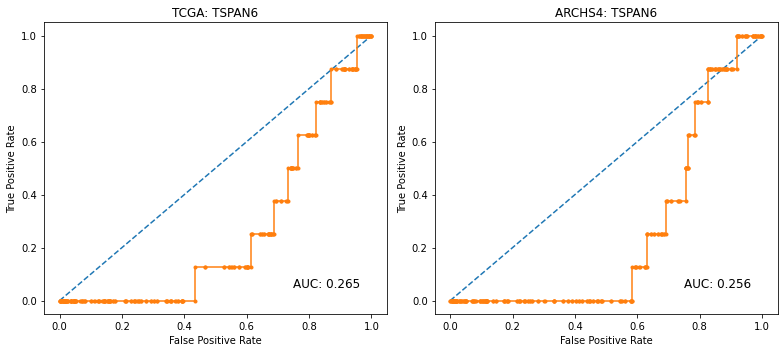

auc
--- 0.8963088989257812 seconds ---
total sec: 123.11897921562195
total min: 2.0519829869270323


,Annotation,Score,Z-Score
1,tryptophan catabolic process (GO:0006569),3.143288,6.033905
2,indolalkylamine catabolic process (GO:0046218),1.288079,1.879734
3,succinyl-CoA metabolic process (GO:0006104),1.000186,1.235086
4,flavonoid glucuronidation (GO:0052696),0.822875,0.838053
5,ethanol catabolic process (GO:0006068),0.738542,0.649214
6,ethanol metabolic process (GO:0006067),0.738542,0.649214
7,glucuronate metabolic process (GO:0019585),0.698396,0.559320
8,xenobiotic glucuronidation (GO:0052697),0.691710,0.544349
9,ketone body metabolic process (GO:1902224),0.675301,0.507606
10,cellular glucuronidation (GO:0052695),0.670866,0.497675


MGI_Mammalian_Phenotype_Level_4_2019
gene_set_dictionaries
--- 13.568142890930176 seconds ---
gs_binary_matrix
--- 7.232911109924316 seconds ---
cor_matrix
--- 15.636971950531006 seconds ---
gene_set_library
--- 52.88842010498047 seconds ---
prediction_matrix
--- 3.765547037124634 seconds ---
prediction_matrix archs4
--- 6.173868894577026 seconds ---
get_top_phenotypes
--- 0.0029201507568359375 seconds ---
get_top_phenotypes archs4
--- 0.0019459724426269531 seconds ---
Not enough gene annotations available.
auc
--- 0.0007979869842529297 seconds ---
total sec: 99.27152609825134
total min: 1.6545254349708558


,Annotation,Score,Z-Score
1,MP:0004525 thin cochlear hair cell stereocilia,0.119713,5.279213
2,MP:0004292 abnormal spiral ligament fibrocyte morphology,0.095269,2.121183
3,MP:0004287 abnormal spiral limbus morphology,0.090619,1.520436
4,MP:0000044 absent organ of Corti,0.088201,1.208008
5,MP:0006083 abnormal blood vessel elastic tissue morphology,0.087886,1.167392
6,MP:0004397 absent cochlear inner hair cells,0.085818,0.900198
7,MP:0010570 prolonged ST segment,0.085344,0.838927
8,MP:0004414 decreased cochlear microphonics,0.084985,0.792581
9,MP:0005199 abnormal iris pigment epithelium,0.083528,0.604350
10,MP:0009742 increased corneal stroma thickness,0.082380,0.456016


ChEA_2016
gene_set_dictionaries
--- 50.26534390449524 seconds ---
gs_binary_matrix
--- 3.0705363750457764 seconds ---


In [ ]:
for lib in libraries:
    process(lib, tcga_genes, filtered_genes, tcga_cor, archs4_genes, archs4_cor)